## Load up packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

wine_palette = sns.xkcd_palette(['dandelion', 'claret'])

## 1: A (brief) review of regression models

To understand how logistic regression works, we'll start with a refresher on standard regression. A regression with one predictor, **x1**, predicting **y** can be specified as:

### $$E[y] = \beta_0 + \sum_{i}^N\beta_ix_i$$

Where:
- **`E[y]`** is the expected value (mean) of y
- **`i thru N`** are the observations (rows) of the data
- **`beta_0`** is the intercept
- **`beta_i`** is the coefficient for the predictor **`x_i`**

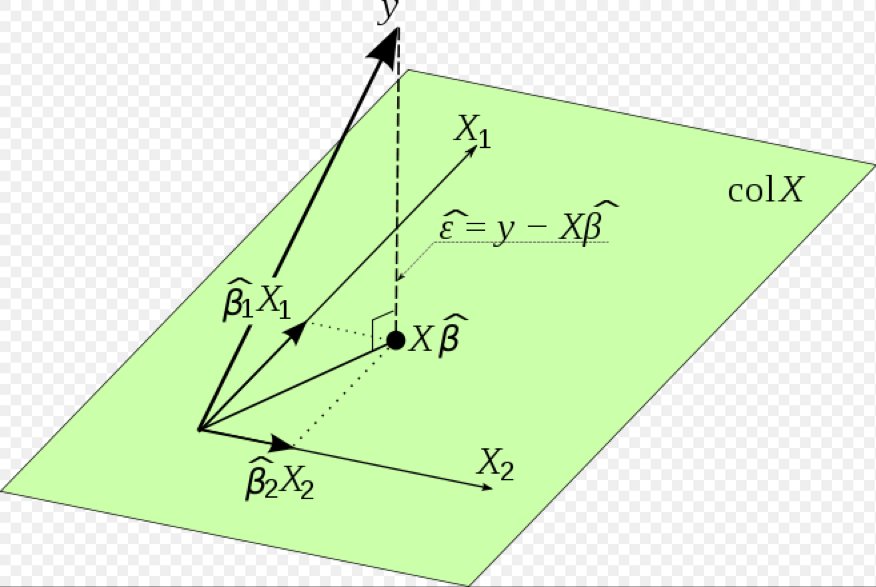

In [2]:
from IPython.display import Image
Image(filename='ols.png')

## 2: Load data

We will be using data on properties of red and white wines. They come in two separate files, one for each class of wine, which we will concatenate together after assigning classes.


You will need to set `delimiter = ';'`

In [2]:
import pandas as pd
red = pd.read_csv('winequality-red.csv', delimiter=';')
white = pd.read_csv('winequality-white.csv', delimiter=';')

#### Add binary columns indicating red wine vs white wine (1 for red, 0 for white)

In [3]:
red['red_wine'] = 1
white['red_wine'] = 0


In [9]:
white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0


#### Concatenate the red and white datasets

In [4]:
wine = pd.concat([red, white])
wine_n = wine.copy()

print wine_n.shape
print red.shape
print white.shape

(6497, 13)
(1599, 13)
(4898, 13)


In [7]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.400000,5,1
1,7.8,0.880,0.00,2.60,0.098,25.0,67.0,0.99680,3.20,0.68,9.800000,5,1
2,7.8,0.760,0.04,2.30,0.092,15.0,54.0,0.99700,3.26,0.65,9.800000,5,1
3,11.2,0.280,0.56,1.90,0.075,17.0,60.0,0.99800,3.16,0.58,9.800000,6,1
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.400000,5,1
5,7.4,0.660,0.00,1.80,0.075,13.0,40.0,0.99780,3.51,0.56,9.400000,5,1
6,7.9,0.600,0.06,1.60,0.069,15.0,59.0,0.99640,3.30,0.46,9.400000,5,1
7,7.3,0.650,0.00,1.20,0.065,15.0,21.0,0.99460,3.39,0.47,10.000000,7,1
8,7.8,0.580,0.02,2.00,0.073,9.0,18.0,0.99680,3.36,0.57,9.500000,7,1
9,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.500000,5,1


#### "Normalize" the non-target columns

**Normalization** in this case means subtracting the column means and dividing by the column standard deviations.

- The **`.mean()`** DataFrame function can calculate the column means
- The **`.std()`** DataFrame function can calculate the column standard deviations

In [6]:
# in logistic regression, make sure you do this step - standardize everything except the indicator 

# standardize/Normalize the columns in red and white. Subtract mean and divide by standard deviation
nc = [x for x in wine.columns if x != 'red_wine']

#nc = normalized columns

wine_n.ix[:, nc] = (wine_n.ix[:, nc] - wine_n.ix[:, nc].mean()) / wine_n.ix[:, nc].std()


In [11]:
wine_n.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
4893,-0.783154,-0.787590,-0.197039,-0.807775,-0.486215,-0.367636,-0.420095,-1.186069,0.320294,-0.210128,0.593772,0.207983,0
4894,-0.474615,-0.119451,0.284664,0.537383,-0.257863,1.491582,0.924517,0.067819,-0.426034,-0.478935,-0.747709,-0.937157,0
4895,-0.551750,-0.605370,-0.885185,-0.891847,-0.429127,-0.029596,-0.083942,-0.719196,-1.421138,-0.478935,-0.915394,0.207983,0
4896,-1.323097,-0.301671,-0.128224,-0.912866,-0.971463,-0.592996,-0.101635,-2.003097,0.755652,-1.016548,1.935253,1.353124,0
4897,-0.937423,-0.787590,0.422293,-0.975920,-1.028551,-0.480316,-0.313942,-1.762991,0.258100,-1.419758,1.096828,0.207983,0


### 3: Plot a regplot predicting binary red_wine column with density

What is wrong with this?

(-0.3, 1.3)

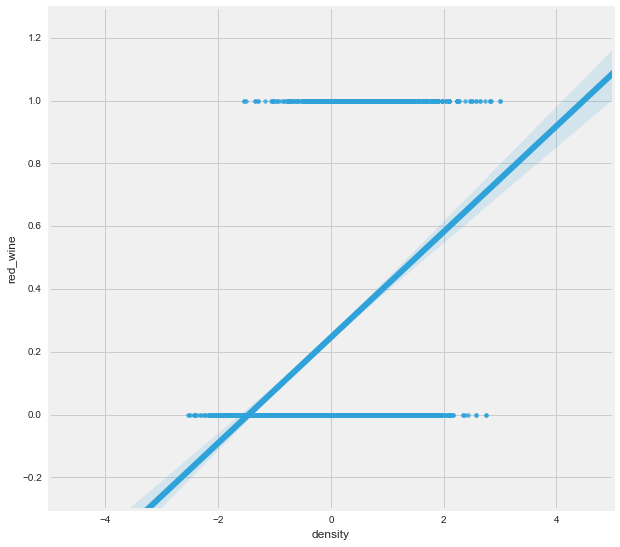

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(9,9)
sns.regplot(wine_n.density, wine_n.red_wine, ax=ax)
ax.set_xlim(-5, 5)
ax.set_ylim(-0.3, 1.3)

In [12]:
#maximum likleyhood estimateion

## 4: What is logistic regression?

As the name implies, logistic regression is also a regression. There is still an intercept and coefficients multiplied by each predictor. 

In the case of logistic regression, however, the target variable is **categorical** as is the case in all classification problems, and therefore the regression is solving for the **probability of classes in the target variable** rather than the mean value of the target variable.

## 5: The binary classes case

Logistic regression can solve problems where there are multiple classes in a couple of ways, but the standard is to solve a binary class problem. To keep things simple we will be looking at the 2-class case.

The logistic regression is still solving for an expected value, but in the binary classification case **this expected value is the probability of one class:**

### $$E[y \in {0,1}] = P(y = 1)$$

In our simple regression formula we now have:

### $$P(y = 1) = \beta_0 + \sum_{i}^N\beta_ix_i$$

## 6: The probability estimation dilemma

### $$P(y = 1) = \beta_0 + \sum_{i}^N\beta_ix_i$$

There is an important problem with this new equation that estimates a probability instead of a real number.

**A. Probabilities are guaranteed to be between 0 and 1.**

**B. Given unknown new predictor values, there is no guarantee that the right hand of the equation will sum to a value between 0 and 1.**

## 7: Odds ratios

We have to modify the regression problem for it to work for predicting probabilities, and the solution relies on the use of **odds ratios**. 

Probabilities can be alternatively expressed as odds ratios. The odds ratio for probability **p** is defined:

### $$\text{odds ratio}(p) = \frac{p}{1-p}$$

The odds ratio of a probability is a measure of **how many times more likely it is than the inverse case**.

For example:

- When **`p = 0.5`**: **`odds ratio = 1`**
    - it is equally likely to happen as it is to not happen.
- When **`p = 0.75`**: **`odds ratio = 3`**
    - it is 3 times more likely to happen than not happen.
- When **`p = 0.40`**: **`odds ratio = 0.666..`**
    - it is 2/3rds as likely to happen than not happen.

In [ ]:
#expected value of y

#https://en.wikipedia.org/wiki/Sigmoid_function

## 8: Odds ratio in place of probability

We can put the odds ratio in place of the probability on the left side of the regression equation.

### $$ \frac{p}{1-p} = \beta_0 + \sum_{i}^N\beta_ix_i$$

But we still have a problem...

The range of odds ratio should be restricted to the range **`[0, infinity]`**

But this means our regression model could still predict **new values of y that are negative and infinity.**

## 9: Log odds

If we take the **natural logarithm** of a variable that falls between 0 and infinity, we transform it into a variable that falls between the range negative infinity and infinity.

The regression can now predict any negative or positive number, and we can convert it back into the odds ratio.

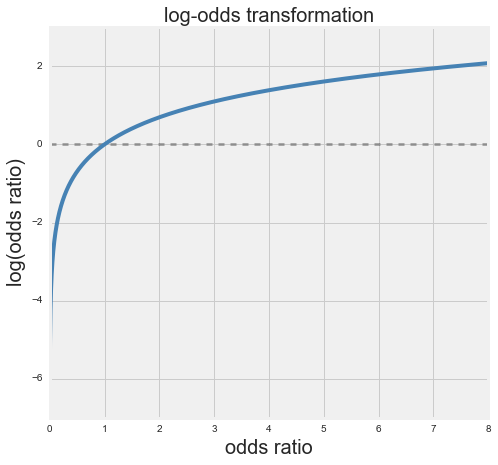

In [18]:
xs = np.linspace(0.001, 8, 3000)
ys = np.log(xs)

plt.figure(figsize=[7,7])
plt.axhline(y=0, linewidth=3, c='k', ls='dashed', alpha=0.3)
plt.plot(xs, ys, lw=4, c='steelblue')

plt.xlabel('odds ratio', fontsize=20)
plt.ylabel('log(odds ratio)', fontsize=20)
plt.title('log-odds transformation',fontsize=20)

## 10: The logit link function

We take the logarithm of the odds ratio to make our regression work. The definition of the transformation between the **probability** and the **logarithm of the odds ratio** is called the **logit link function**.

### $$\text{logit}\big(E[y]\big) = \text{logit}\big(P(y=1)\big) = log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) = \beta_0 + \sum_{i}^N\beta_ix_i$$

Link functions such as the logit define a relationship between linear predictors and the mean of the target variable.

### $$log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg)$$

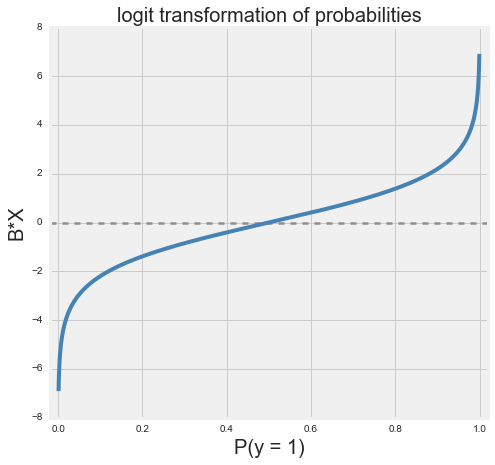

In [19]:
probs = np.linspace(0.001, 0.999, 2000)
logits = np.log((probs/(1-probs)))

plt.figure(figsize=[7,7])
plt.axhline(y=0, linewidth=3, c='k', ls='dashed', alpha=0.3)
plt.plot(probs, logits, lw=4, c='steelblue')

plt.xlim(-0.02, 1.02)

plt.xlabel('P(y = 1)', fontsize=20)
plt.ylabel('B*X', fontsize=20)
plt.title('logit transformation of probabilities',fontsize=20)

## 1.8: Inverting the logit link function into the logistic function

The inversion of the logit link function is called the **logistic function**. By inverting the logit, we can have the right side of our regression equation explicitly solving for **`P(y = 1)`** instead of the log odds.

### $$P(y=1) = logit^{-1}\bigg(\beta_0 + \sum_{i}^N\beta_ix_i\bigg)$$

Where:

### $$logit^{-1}(a) = logistic(a) = \frac{e^{a}}{e^{a} + 1}$$ 

Giving us:

### $$P(y=1) = \frac{e^{\big(\beta_0 + \sum_{i}^N\beta_ix_i\big)}}{e^{\big(\beta_0 + \sum_{i}^N\beta_ix_i\big)}+1}$$

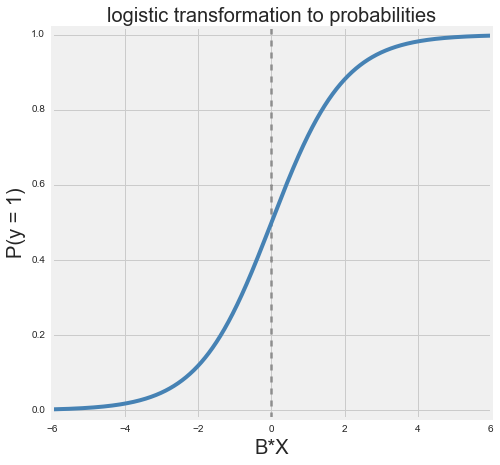

In [20]:
values = np.linspace(-6, 6, 2000)
probs = np.exp(values)/(np.exp(values)+1)

plt.figure(figsize=[7,7])
plt.axvline(x=0, linewidth=3, c='k', ls='dashed', alpha=0.3)
plt.plot(values, probs, lw=4, c='steelblue')

plt.ylim(-0.02, 1.02)

plt.xlabel('B*X', fontsize=20)
plt.ylabel('P(y = 1)', fontsize=20)
plt.title('logistic transformation to probabilities',fontsize=20)

In [21]:
# beta0 +beta1X1 + beta2x2 + betaex3

In [22]:
#sentiment analysis

In [23]:
# min k value = 3 (maybe should always be odd)

In [24]:
# given can we predict based on 1 row of data?

In [25]:
import statsmodels.api as sm

In [30]:
logit = sm.Logit(wine_n.red_wine, wine_n.density)
logit

In [34]:
prediction = logit.fit()

Optimization terminated successfully.
         Current function value: 0.632394
         Iterations 5


In [37]:
prediction.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: -0.133   
Dependent Variable: red_wine         AIC:              8219.3317
Date:               2016-06-28 10:23 BIC:              8226.1108
No. Observations:   6497             Log-Likelihood:   -4108.7  
Df Model:           0                LL-Null:          -3625.5  
Df Residuals:       6496             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
density     0.7620     0.0291   26.2085   0.0000   0.7050   0.8189
================================================================

"""